In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
from matplotlib.cm import get_cmap
from scipy.stats import truncnorm, qmc
from tqdm import tqdm
import scipy.stats as stats
from scipy.stats import wasserstein_distance, ks_2samp
import seaborn as sns
from itertools import product
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import uniform
from matplotlib import colormaps
import matplotlib.colors as mcolors
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from torch.distributions import Distribution, Uniform, HalfNormal
from torch.distributions.utils import broadcast_all
import math
from ili.utils.distributions_pt import CustomIndependent
import itertools
import emcee

import symbolic_pofk.syren_new as syren_new
import symbolic_pofk.linear as linear
import pickle

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
sns.set(style="whitegrid", context="paper")

/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [19]:
with open('/home/x-ctirapongpra/scratch/sci-2-dim-models/uniform_power/posterior.pkl', 'rb') as f:
    posterior_ensemble_old = pickle.load(f)
with open('/home/x-ctirapongpra/scratch/sci-2-dim-models/tailed_power/posterior.pkl', 'rb') as f:
    posterior_ensemble = pickle.load(f)
with open('/home/x-ctirapongpra/scratch/sci-2-dim-models/nle_power/posterior.pkl', 'rb') as f:
    posterior_ensemble_nle = pickle.load(f)

In [3]:
class TailedNormal(Distribution):
    arg_constraints = {
        'a': torch.distributions.constraints.real,
        'b': torch.distributions.constraints.dependent,
        'sigma': torch.distributions.constraints.positive,
    }
    support = torch.distributions.constraints.real
    has_rsample = False

    def __init__(self, a, b, sigma, validate_args=None):
        self.a, self.b, self.sigma = broadcast_all(a, b, sigma)
        if torch.any(self.a >= self.b):
            raise ValueError("`a` must be less than `b`.")
        
        self.Z = math.sqrt(2 * math.pi) * self.sigma + (self.b - self.a)
        self.A = math.sqrt(2 * math.pi) * self.sigma / self.Z
        self.B = (self.b - self.a) / self.Z

        self.halfnormal = HalfNormal(self.sigma)

        super().__init__(batch_shape=self.a.size(), validate_args=validate_args)

    def log_prob(self, x):
        x, a, b, sigma = broadcast_all(x, self.a, self.b, self.sigma)

        logA = torch.log(self.A.to(dtype=x.dtype, device=x.device))
        logB = torch.log(self.B.to(dtype=x.dtype, device=x.device))
        log_uniform = logB - torch.log(b - a)

        # left: x <= a => z = a - x
        z_left = torch.abs(a - x)
        log_halfnorm_left = self.halfnormal.log_prob(z_left) + logA - math.log(2.0)

        # right: x >= b => z = x - b
        z_right = torch.abs(x - b)
        log_halfnorm_right = self.halfnormal.log_prob(z_right) + logA - math.log(2.0)

        return torch.where(x <= a, log_halfnorm_left,
               torch.where(x >= b, log_halfnorm_right,
               log_uniform))

    def cdf(self, x):
        x, a, b, sigma = broadcast_all(x, self.a, self.b, self.sigma)
        sqrt2 = math.sqrt(2.0)

        def Phi(z):  # Standard Normal CDF
            return 0.5 * (1 + torch.erf(z / sqrt2))

        left_cdf = self.A * Phi((x - a) / sigma)
        center_cdf = 0.5 * self.A + self.B * (x - a) / (b - a)
        right_cdf = self.B + self.A * Phi((x - b) / sigma)

        return torch.where(x <= a, left_cdf,
               torch.where(x >= b, right_cdf,
               center_cdf))
    
    def icdf(self, u):
        # Helper function for the Inverse Standard Normal CDF
        def inv_Phi(p):
            # Clamping p to avoid NaNs from erfinv at the boundaries 0 and 1
            p_clamped = torch.clamp(p, 1e-9, 1.0 - 1e-9)
            return math.sqrt(2.0) * torch.erfinv(2.0 * p_clamped - 1.0)

        # Thresholds dividing the distribution regions
        thresh_left = 0.5 * self.A
        thresh_right = 1.0 - 0.5 * self.A

        u_left_norm = u / self.A
        left_tail = self.a + self.sigma * inv_Phi(u_left_norm)

        u_right_norm = (u - self.B) / self.A
        right_tail = self.b + self.sigma * inv_Phi(u_right_norm)

        u_middle_norm = (u - thresh_left) / self.B
        middle = self.a + u_middle_norm * (self.b - self.a)

        return torch.where(u < thresh_left, left_tail,
                           torch.where(u > thresh_right, right_tail, middle))
        

    def sample(self, sample_shape=torch.Size()):
        u = torch.rand(sample_shape + self.a.shape, device=self.a.device)
        thresh_left = 0.5 * self.A
        thresh_right = 1.0 - 0.5 * self.A

        left_tail = self.a - self.halfnormal.sample(sample_shape)
        right_tail = self.b + self.halfnormal.sample(sample_shape)

        x_middle = self.a + (u - thresh_left) * (self.b - self.a) / self.B

        return torch.where(u < thresh_left, left_tail,
               torch.where(u > thresh_right, right_tail,
               x_middle))
    
    def sample_lhs(self, n_samples):
        """Sample using Latin Hypercube Sampling"""
        # Generate LHS samples in [0,1]^d
        sampler = qmc.LatinHypercube(d=len(self.a.flatten()), seed=42)
        u_samples = sampler.random(n_samples)
        u_tensor = torch.tensor(u_samples, dtype=torch.float32, device=self.a.device)
        
        # Transform using inverse CDF
        return self.icdf(u_tensor)

    def mean(self):
        return 0.5 * (self.a + self.b)

IndependentTailedNormal = type('IndependentTailedNormal', (CustomIndependent,), {'Distribution': TailedNormal})

In [4]:
# Fixed
L, N = 1000, 128
kf = 2*np.pi/L
knyq = np.pi*N/L
kedges = np.arange(0, knyq, kf)
kcenters = (kedges[:-1] + kedges[1:])/2
a = 1.0

def simulator(theta):
   """Simulator: theta -> P(k)"""
   Om, h = theta
   # Also fixed (for now)
   As = 2.105  # 10^9 A_s
   Ob = 0.02242 / h ** 2
   ns = 0.9665
   w0 = -1.0  
   wa = 0.0
   mnu = 0.0
   pk_syren_theory = syren_new.pnl_new_emulated(
         kcenters, As, Om, Ob, h, ns, mnu, w0, wa, a=a
      )

   var_single = np.abs(pk_syren_theory)**2
   Nk = L**3 * kcenters**2 * kf / (2*np.pi**2)
   var_mode = var_single * 2 / Nk
   std_mode = np.sqrt(var_mode)

   pk_w_noise = pk_syren_theory + std_mode*np.random.randn(*pk_syren_theory.shape)
   return pk_w_noise

In [5]:
class SBIEvaluator:
   def __init__(self, param_names=['θ₁', 'θ₂']):
       self.param_names = param_names
   
   def c2st(self, X1, X2):
       """C2ST score - lower is better (0.5 = identical distributions)"""
       X = np.vstack([X1, X2])
       y = np.concatenate([np.zeros(len(X1)), np.ones(len(X2))])
       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
       clf = LogisticRegression(max_iter=1000)
       y_pred = clf.fit(X_train, y_train).predict(X_test)
       return hamming_loss(y_test, y_pred)
   
   def tarp_score(self, samples, true_theta):
       """TARP calibration score - lower is better"""
       alpha_levels = np.linspace(0.05, 0.95, 19)
       empirical_coverage = []
       
       for alpha in alpha_levels:
           coverage = all(
               np.percentile(samples[:, j], 100*alpha/2) <= true_theta[j] <= 
               np.percentile(samples[:, j], 100*(1-alpha/2))
               for j in range(len(true_theta))
           )
           empirical_coverage.append(coverage)
       
       expected_coverage = 1 - alpha_levels
       return np.mean(np.abs(expected_coverage - empirical_coverage))
   
   def compare(self, samples_dict, true_theta):
       """Compare multiple methods"""
       results = {}
       methods = list(samples_dict.keys())
       
       for method, samples in samples_dict.items():
           results[method] = {
               'tarp': self.tarp_score(samples, true_theta),
               'mean': np.mean(samples, axis=0),
               'std': np.std(samples, axis=0),
               'c2st_vs_others': {}
           }
       
       # C2ST comparisons
       for i, method1 in enumerate(methods):
           for method2 in methods[i+1:]:
               score = self.c2st(samples_dict[method1], samples_dict[method2])
               results[method1]['c2st_vs_others'][method2] = score
               results[method2]['c2st_vs_others'][method1] = score
       
       return results
   
   def print_results(self, results, true_theta):
       """Print concise comparison"""
       methods = list(results.keys())
       
       print("Method Comparison")
       print("-" * 50)
       
       for method in methods:
           stats = results[method]
           print(f"\n{method}:")
           print(f"  TARP: {stats['tarp']:.4f}")
           for i, param in enumerate(self.param_names):
               print(f"  {param}: Mean={stats['mean'][i]:.3f}, Std={stats['std'][i]:.3f}")
           
           if stats['c2st_vs_others']:
               c2st_str = ", ".join([f"{k}={v:.3f}" for k, v in stats['c2st_vs_others'].items()])
               print(f"  C2ST: {c2st_str}")

In [6]:
n_posterior_samples = 10000
n_simulations = 10000

# Parameter ranges [Om, h]
param_1_range = (0.24, 0.40)   # Om
param_2_range = (0.61, 0.73)    # h
param_ranges = [param_1_range, param_2_range]

param_1_width = param_1_range[1] - param_1_range[0]
param_2_width = param_2_range[1] - param_2_range[0]

# Scale sigma relative to parameter ranges
sigma_scale = 0.1
sigmas = [sigma_scale * (high - low) for low, high in param_ranges]

param_1_mean = (param_1_range[0] + param_1_range[1]) / 2  # Om mean
param_2_mean = (param_2_range[0] + param_2_range[1]) / 2  # h mean

param_1_std = 0.1 * (param_1_range[1] - param_1_range[0])   # Om std
param_2_std = 0.1 * (param_2_range[1] - param_2_range[0])   # h std

In [7]:
def forward_model_deterministic(theta):
    """
    Deterministic forward model: theta -> P_theory(k)
    Returns noiseless theoretical power spectrum

    Args:
        theta: [Om, h] cosmological parameters
    Returns:
        P_theory: theoretical power spectrum (no noise)
    """
    Om, h = theta

    # Fixed cosmological parameters
    As = 2.105  # 10^9 A_s
    Ob = 0.02242 / h ** 2
    ns = 0.9665
    w0 = -1.0
    wa = 0.0
    mnu = 0.0

    # Get theoretical power spectrum (no noise)
    pk_syren_theory = syren_new.pnl_new_emulated(kcenters, As, Om, Ob, h, ns, mnu, w0, wa, a=a)

    return pk_syren_theory


def compute_cosmic_variance_std(P_theory):
    """
    Compute cosmic variance uncertainties for power spectrum

    Args:
        P_theory: theoretical power spectrum
    Returns:
        std_mode: standard deviation per k-bin
    """
    var_single = np.abs(P_theory)**2
    Nk = L**3 * kcenters**2 * kf / (2*np.pi**2)
    var_mode = var_single * 2 / Nk
    std_mode = np.sqrt(var_mode)
    return std_mode


def log_prior(theta):
    """
    Log prior probability (Normal distributions)

    Args:
        theta: [Om, h] parameters
    Returns:
        log_prior: log prior probability
    """
    Om, h = theta

    # Normal prior for Om
    log_prior_Om = -0.5 * ((Om - param_1_mean) / param_1_std)**2

    # Normal prior for h
    log_prior_h = -0.5 * ((h - param_2_mean) / param_2_std)**2

    return log_prior_Om + log_prior_h


def log_likelihood(theta, x_obs):
    """
    Log likelihood function

    Args:
        theta: [Om, h] parameters
        x_obs: observed power spectrum data
    Returns:
        log_likelihood: log likelihood value
    """
    # Forward model
    P_theory = forward_model_deterministic(theta)

    # Noise model
    std_mode = compute_cosmic_variance_std(P_theory)

    # Gaussian likelihood
    log_like = -0.5 * np.sum(((x_obs - P_theory) / std_mode)
                             ** 2) - np.sum(np.log(std_mode))

    return log_like

# log ratio = log like1 - log like2

def log_probability(theta, x_obs):
    """
    Log posterior probability

    Args:
        theta: [Om, h] parameters
        x_obs: observed power spectrum data
    Returns:
        log_posterior: log posterior probability
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf

    return lp + log_likelihood(theta, x_obs)

In [8]:
def run_mcmc_inference(
        x_obs, num_samples=1000, warmup_steps=500, num_chains=4,
        verbose=True):
    """
    Run MCMC inference using emcee sampler

    Args:
        x_obs: observed power spectrum data (numpy array)
        num_samples: number of MCMC samples per chain
        warmup_steps: number of warmup steps
        num_chains: number of parallel walkers

    Returns:
        samples: dictionary of parameter samples
        sampler: emcee sampler object for diagnostics
    """
    # Ensure x_obs is numpy array
    if not isinstance(x_obs, np.ndarray):
        x_obs = np.array(x_obs)

    # Initialize walkers with random positions within prior range
    pos = np.random.rand(num_chains, 2)
    pos[:, 0] = pos[:, 0] * \
        (param_1_range[1] - param_1_range[0]) + param_1_range[0]  # Om
    pos[:, 1] = pos[:, 1] * \
        (param_2_range[1] - param_2_range[0]) + param_2_range[0]  # h

    # Set up sampler
    sampler = emcee.EnsembleSampler(
        num_chains, 2, log_probability, args=(x_obs,))

    if verbose:
        print(
            f"Running MCMC with {num_samples} samples, {warmup_steps} warmup steps, {num_chains} walkers...")
        print(
            f"Om range: [{param_1_range[0]:.4f}, {param_1_range[1]:.4f}], std: {param_1_std:.4f}")
        print(
            f"h range:  [{param_2_range[0]:.4f}, {param_2_range[1]:.4f}], std: {param_2_std:.4f}")

    # Run warmup
    state = sampler.run_mcmc(pos, warmup_steps)
    sampler.reset()

    # Run production
    sampler.run_mcmc(state, num_samples)

    # Extract samples
    chain = sampler.get_chain(flat=True)
    samples_np = {
        'Om': chain[:, 0],
        'h': chain[:, 1]
    }

    return samples_np, sampler

In [9]:
# Training for edge cases
# Define theta_true close to the lower bounds of each parameter

theta_true_edge = np.array([
    param_1_range[0] + 0.1 * param_1_width,
    param_2_range[0] + 0.1 * param_2_width
])

print(f"Parameter ranges:")
print(f"  Param 1: [{param_ranges[0][0]}, {param_ranges[0][1]}] -> selected: {theta_true_edge[0]:.3f}")
print(f"  Param 2: [{param_ranges[1][0]}, {param_ranges[1][1]}] -> selected: {theta_true_edge[1]:.3f}")

# Generate observation using the edge case theta_true
x_obs_edge = simulator(theta_true_edge)

# Sample from uniform-trained model
samples_uniform = posterior_ensemble_old.sample((n_posterior_samples,), x_obs_edge).cpu().numpy()

# Sample from TailedNormal-trained model  
samples_tailed = posterior_ensemble.sample((n_posterior_samples,), x_obs_edge).cpu().numpy()

# Get noiseless prediction
P_theory_true = forward_model_deterministic(theta_true_edge)

# Get noise level
std_true = compute_cosmic_variance_std(P_theory_true)

# Add noise
x_obs = P_theory_true + std_true * np.random.randn(*P_theory_true.shape)

# Generate observation using YOUR function
print("\nGenerating reference observation...")
reference_samples_dict, sampler = run_mcmc_inference(
    x_obs_edge,
    num_samples=3000,      # samples per walker
    warmup_steps=500,       # burn-in steps
    num_chains=4           # number of walkers (should be >= 2*ndim)
)

# Convert dictionary to numpy array for consistency
reference_samples = np.column_stack([reference_samples_dict['Om'], reference_samples_dict['h']])

Parameter ranges:
  Param 1: [0.24, 0.4] -> selected: 0.256
  Param 2: [0.61, 0.73] -> selected: 0.622


Drawing 5295 posterior samples:   0%|          | 0/5295 [00:00<?, ?it/s]

Drawing 515 posterior samples: 100%|██████████| 515/515 [00:00<00:00, 130423.05it/s]



Generating reference observation...
Running MCMC with 3000 samples, 500 warmup steps, 4 walkers...
Om range: [0.2400, 0.4000], std: 0.0160
h range:  [0.6100, 0.7300], std: 0.0120


In [10]:
# Create evaluator and run comparison
evaluator = SBIEvaluator()

samples_dict = {
    'MCMC_Reference': reference_samples,
    'Uniform_NPE': samples_uniform,
    'TailedNormal_NPE': samples_tailed
}

results = evaluator.compare(samples_dict, theta_true_edge)
evaluator.print_results(results, theta_true_edge)

Method Comparison
--------------------------------------------------

MCMC_Reference:
  TARP: 0.2789
  θ₁: Mean=0.254, Std=0.002
  θ₂: Mean=0.624, Std=0.002
  C2ST: Uniform_NPE=0.087, TailedNormal_NPE=0.448

Uniform_NPE:
  TARP: 0.3737
  θ₁: Mean=0.319, Std=0.046
  θ₂: Mean=0.569, Std=0.037
  C2ST: MCMC_Reference=0.087, TailedNormal_NPE=0.109

TailedNormal_NPE:
  TARP: 0.3737
  θ₁: Mean=0.254, Std=0.020
  θ₂: Mean=0.625, Std=0.018
  C2ST: MCMC_Reference=0.448, Uniform_NPE=0.109


Saved plot: sci-2-dim-figures/histogram.png


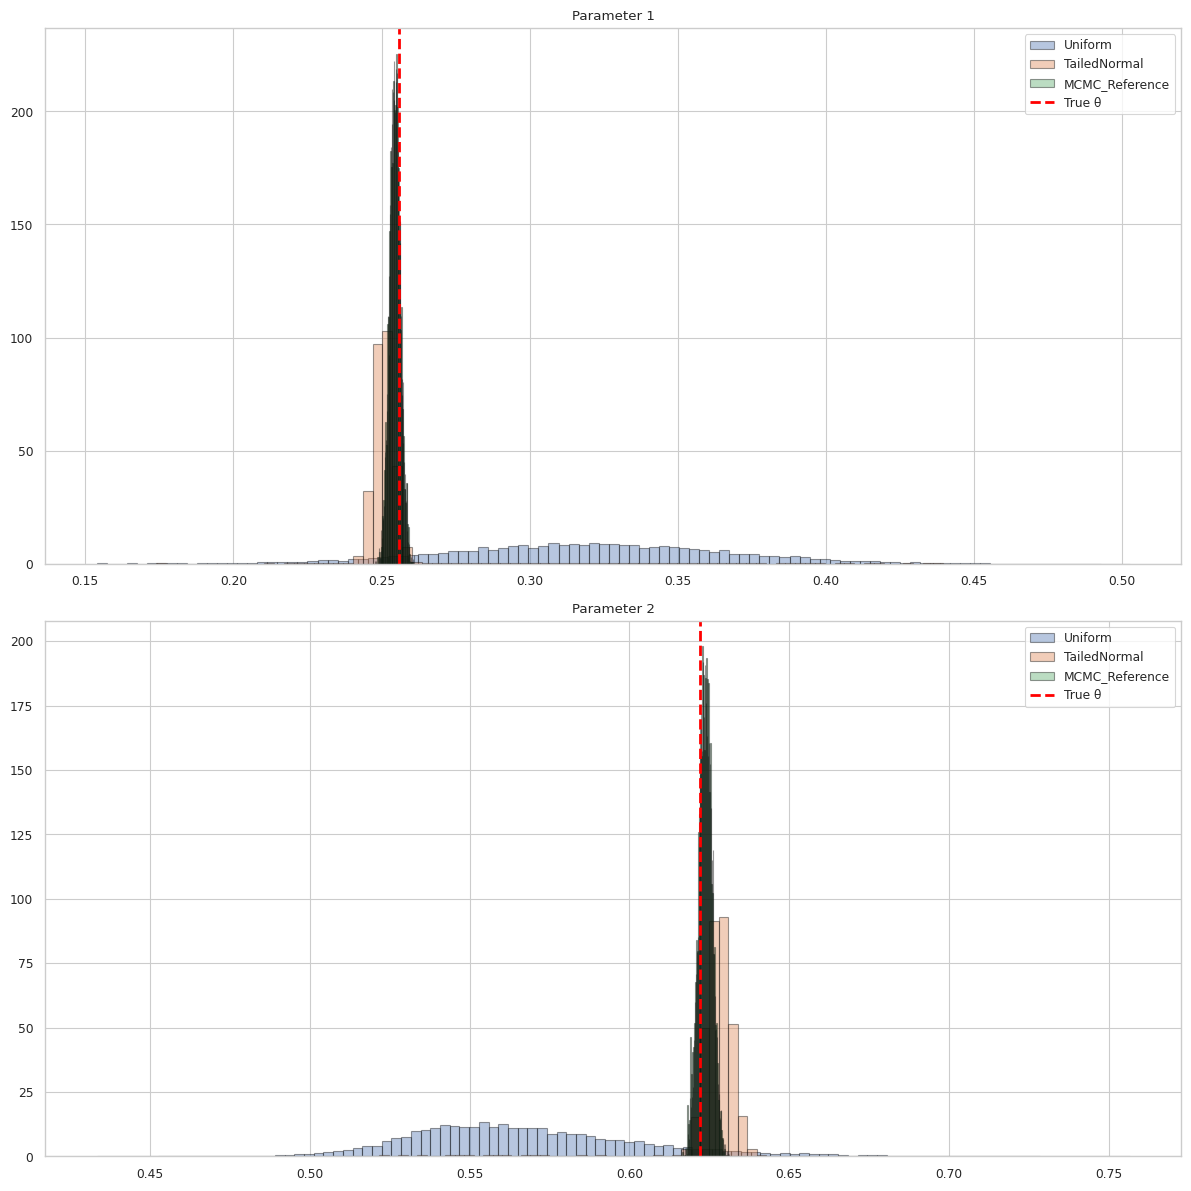

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

methods = ['Uniform', 'TailedNormal', 'MCMC_Reference']
samples_list = [samples_uniform, samples_tailed, reference_samples]

for i, param in enumerate(['Parameter 1', 'Parameter 2']):
   for method, samples in zip(methods, samples_list):
       axes[i].hist(samples[:, i], bins=100, alpha=0.4, density=True, label=method, edgecolor='black')
   axes[i].axvline(theta_true_edge[i], color='red', linestyle='--', linewidth=2, label='True θ')
   axes[i].set_title(f'{param}')
   axes[i].legend()

plt.tight_layout()
os.makedirs('sci-2-dim-figures', exist_ok=True)
filename = f'sci-2-dim-figures/histogram.png'
plt.savefig(filename, bbox_inches='tight')
print(f"Saved plot: {filename}")
plt.show()

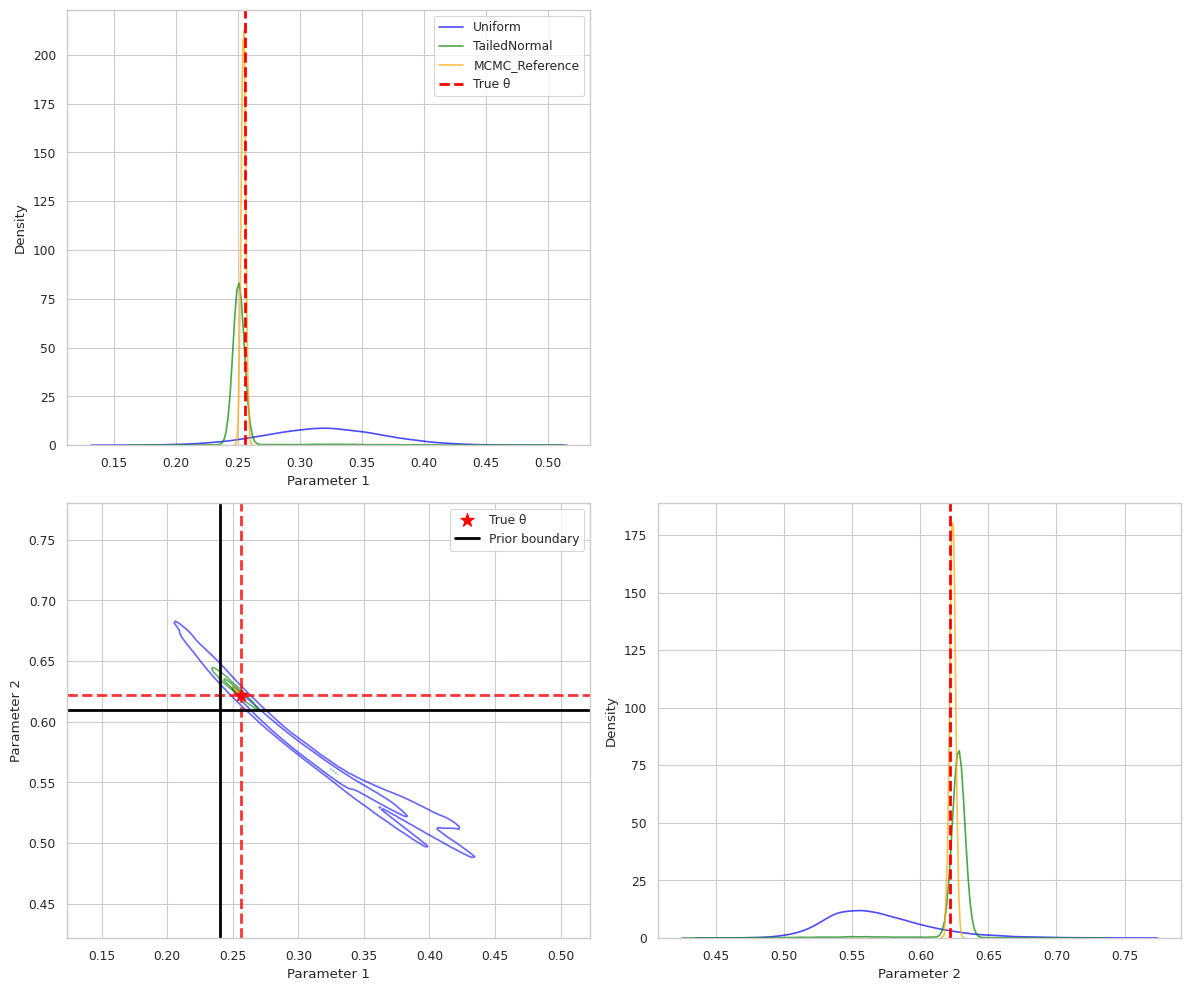

In [12]:
# Create corner plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

colors = ['blue', 'green', 'orange']
param_names = ['Parameter 1', 'Parameter 2']

# Plot marginal distributions (diagonal)
for i in range(2):
    ax = axes[i, i]
    for method, samples, color in zip(methods, samples_list, colors):
        sns.kdeplot(data=samples[:, i], ax=ax, label=method, color=color, alpha=0.7)
    
    # Add true parameter line
    ax.axvline(theta_true_edge[i], color='red', linestyle='--', linewidth=2, label='True θ')
    ax.set_xlabel(param_names[i])
    ax.set_ylabel('Density')
    if i == 0:
        ax.legend()

# Plot joint distributions (off-diagonal)
ax = axes[1, 0]  # Bottom-left for joint distribution
for method, samples, color in zip(methods, samples_list, colors):
    sns.kdeplot(x=samples[:, 0], y=samples[:, 1], ax=ax, color=color, alpha=0.6, 
                levels=[0.05, 0.32, 1], label=method, fill=False)

# Add true parameter point
ax.scatter(theta_true_edge[0], theta_true_edge[1], color='red', s=100, 
           marker='*', label='True θ', zorder=10)

# Add red lines to show true parameter values as boundaries
ax.axvline(theta_true_edge[0], color='red', linestyle='--', linewidth=2, alpha=0.8)
ax.axhline(theta_true_edge[1], color='red', linestyle='--', linewidth=2, alpha=0.8)

# Add black boundary at prior edge (x=1 and y=1)
ax.axvline(param_1_range[0], color='black', linestyle='-', linewidth=2, alpha=1.0, label='Prior boundary')
ax.axhline(param_2_range[0], color='black', linestyle='-', linewidth=2, alpha=1.0)

ax.set_xlabel(param_names[0])
ax.set_ylabel(param_names[1])
ax.legend()

# Remove top-right subplot (not needed in corner plot)
axes[0, 1].remove()

plt.tight_layout()
plt.show()

/tmp/ipykernel_390732/1678322484.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=methods)
/tmp/ipykernel_390732/1678322484.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=methods)


Saved plot: sci-2-dim-figures/boxpot.png


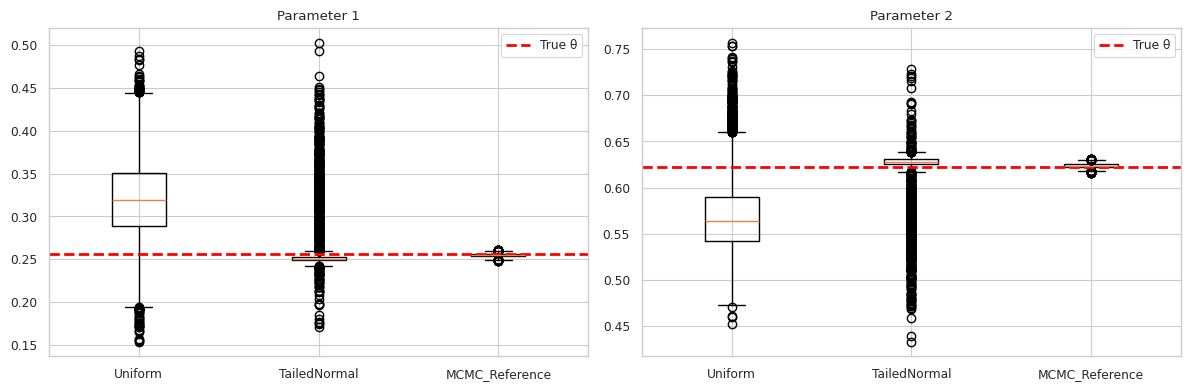

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
samples_list = [samples_uniform, samples_tailed, reference_samples]

for i, param in enumerate(['Parameter 1', 'Parameter 2']):
   data = [samples[:, i] for samples in samples_list]
   
   axes[i].boxplot(data, labels=methods)
   axes[i].axhline(theta_true_edge[i], color='red', linestyle='--', linewidth=2, label='True θ')
   axes[i].set_title(f'{param}')
   axes[i].legend()

plt.tight_layout()
filename = f'sci-2-dim-figures/boxpot.png'
plt.savefig(filename, bbox_inches='tight')
print(f"Saved plot: {filename}")
plt.show()

In [ ]:
class GridEvaluator:
    def __init__(self, simulator, param_ranges):
        self.simulator = simulator
        self.param_ranges = param_ranges

    def create_test_points(self, n_points_per_dim):
        """Create test points on rectangular grid"""
        x_points = np.linspace(self.param_ranges[0][0], self.param_ranges[0][1], n_points_per_dim)
        y_points = np.linspace(self.param_ranges[1][0], self.param_ranges[1][1], n_points_per_dim)
        
        test_points = []
        for x in x_points:
            for y in y_points:
                test_points.append([x, y])
        
        return np.array(test_points)

    def evaluate_all(self, posterior_dict, posterior_ensemble_nle, test_points, n_samples=1000):
        """Evaluate all posteriors including NLE ensemble"""
        observations = []
        results = {'test_points': test_points}

        # Generate observations for all test points
        for theta in tqdm(test_points, desc="Generating observations"):
            x_obs = self.simulator(theta)
            observations.append(x_obs)

        results['observations'] = observations

        # Sample from NLE ensemble (replaces reference posterior)
        nle_samples = []
        for x_obs in tqdm(observations, desc="NLE Ensemble"):
            samples_nle = posterior_ensemble_nle.sample(
                (n_samples,), x_obs, 
                method='slice_np_vectorized', num_chains=20
            ).detach().cpu().numpy()
            nle_samples.append(samples_nle)
        results['NLE_Ensemble'] = nle_samples

        # Sample from NPE posteriors
        for name, posterior in posterior_dict.items():
            samples = []
            for x_obs in tqdm(observations, desc=name):
                samples.append(posterior.sample((n_samples,), x_obs).cpu().numpy())
            results[name] = samples

        return results

    def c2st(self, X1, X2):
        """C2ST score"""
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LogisticRegression
        from sklearn.metrics import hamming_loss

        X = np.vstack([X1, X2])
        y = np.concatenate([np.zeros(len(X1)), np.ones(len(X2))])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        return hamming_loss(y_test, LogisticRegression(max_iter=1000).fit(X_train, y_train).predict(X_test))

    def compute_c2st_grid(self, results, n_points_per_dim):
        """Compute C2ST for grid points"""
        methods = ['Uniform_NPE', 'TailedNormal_NPE', 'NLE_Ensemble']
        c2st_grid = {}

        for i, m1 in enumerate(methods):
            for m2 in methods[i+1:]:
                comparison_name = f"{m1}_vs_{m2}"
                c2st_values = []
                
                for idx in range(len(results['test_points'])):
                    c2st_val = self.c2st(results[m1][idx], results[m2][idx])
                    c2st_values.append(c2st_val)
                
                c2st_grid[comparison_name] = np.array(c2st_values).reshape(n_points_per_dim, n_points_per_dim)

        return c2st_grid

    def plot_c2st_grid(self, c2st_grid, n_points_per_dim):
        """Plot C2ST scores as heatmaps"""
        sns.set(style="white")
        comparisons = list(c2st_grid.keys())
        fig, axes = plt.subplots(len(comparisons), 1, figsize=(10, 8*len(comparisons)))
        if len(comparisons) == 1: 
            axes = [axes]

        for i, comp in enumerate(comparisons):
            im = axes[i].imshow(c2st_grid[comp], cmap='RdYlBu_r', vmin=0.3, vmax=0.6, 
                               extent=[self.param_ranges[0][0], self.param_ranges[0][1], 
                                      self.param_ranges[1][0], self.param_ranges[1][1]], 
                               origin='lower')
            
            # Add text annotations
            for j in range(n_points_per_dim):
                for k in range(n_points_per_dim):
                    value = c2st_grid[comp][j, k]
                    color = 'white' if value > 0.5 else 'black'
                    
                    # Calculate pixel coordinates for centering
                    x_extent = self.param_ranges[0][1] - self.param_ranges[0][0]
                    y_extent = self.param_ranges[1][1] - self.param_ranges[1][0]
                    x_pos = self.param_ranges[0][0] + (k + 0.5) * x_extent / n_points_per_dim
                    y_pos = self.param_ranges[1][0] + (j + 0.5) * y_extent / n_points_per_dim
                    
                    axes[i].text(x_pos, y_pos, f'{value:.2f}', ha='center', va='center', 
                               color=color, fontweight='bold', fontsize=6)
            
            axes[i].set_title(comp.replace('_', ' '), fontsize=16)
            axes[i].set_xlabel('Parameter 1', fontsize=14)
            axes[i].set_ylabel('Parameter 2', fontsize=14)
            fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04, label='C2ST Score')

        plt.tight_layout()
        filename = 'sci-2-dim-figures/heatmap_nle.png'
        plt.savefig(filename, bbox_inches='tight')
        print(f"Saved plot: {filename}")
        plt.show()

TailedNormal_NPE: 100%|██████████| 25/25 [00:00<00:00, 72.32it/s]


Saved plot: toy-2-dim-figures/heatmap_nle.png


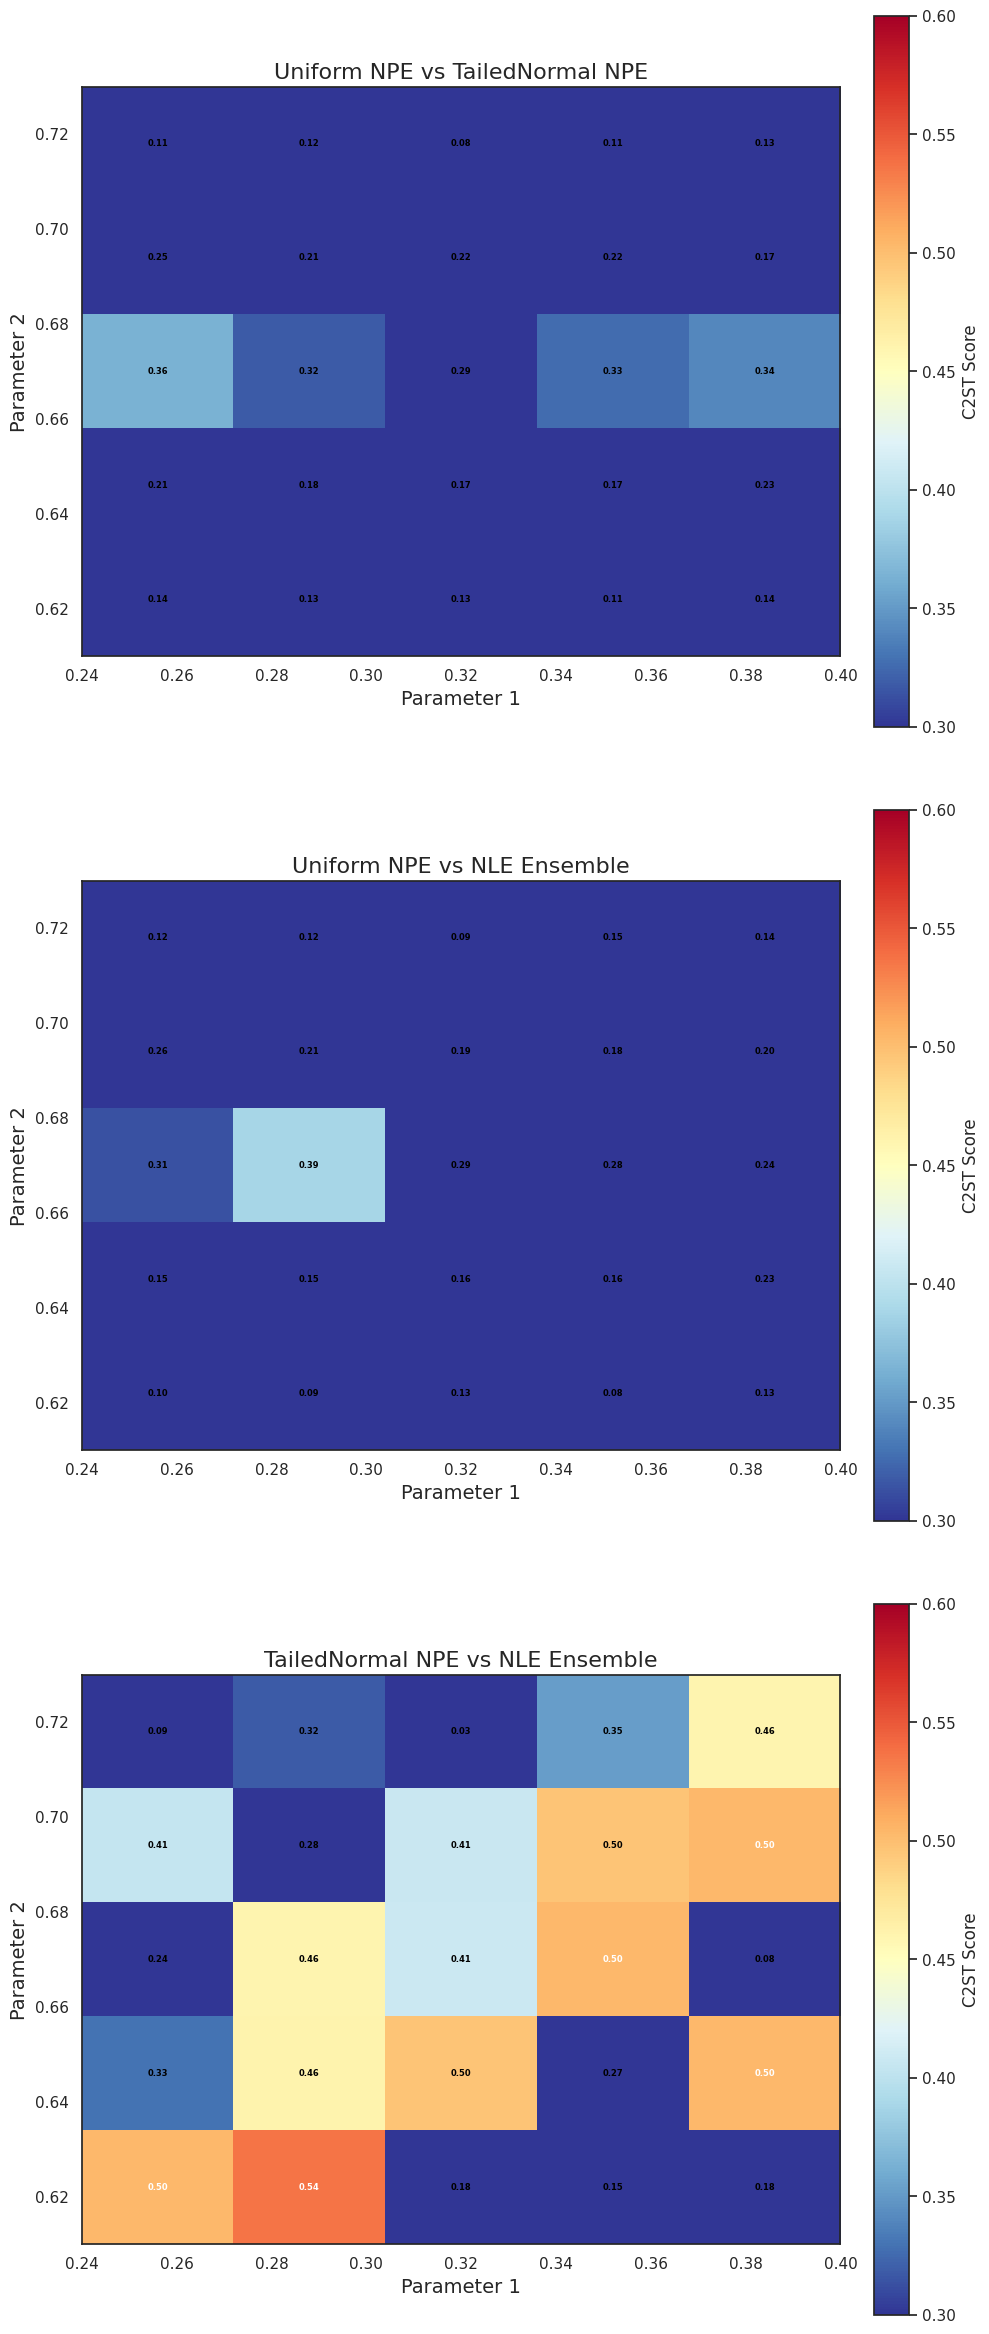

In [23]:
evaluator = GridEvaluator(simulator, param_ranges)
test_points = evaluator.create_test_points(n_points_per_dim=5)

# Define posteriors to compare
posterior_dict = {
    'Uniform_NPE': posterior_ensemble_old,
    'TailedNormal_NPE': posterior_ensemble
}
results = evaluator.evaluate_all(posterior_dict, posterior_ensemble_nle, test_points, n_samples=1000)
c2st_grid = evaluator.compute_c2st_grid(results, n_points_per_dim=5)
evaluator.plot_c2st_grid(c2st_grid, n_points_per_dim=5)